# Constitution of a corpus of NLP papers from two sources: ACL Anthology and ArXiv

**In this Notebook**: We will create two `Corpus` objects and populate them with `Paper`(s), whose content will be further investigated. We use two sources of papers (XML format) and metadata: [the ACL Anthology](#a-acl-corpus) and [ArXiv](#b-arxiv-corpus).

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import json
import re
import tqdm
import os
from matplotlib import pyplot as plt
from collections import Counter
import utils.Corpus

## A. ACL corpus

### 1. Initial data inspection

Data source: [ACL Anthology corpus](https://github.com/shauryr/ACL-anthology-corpus) by Shaurya Rohatgi (metadata + grobid extractions as XML files).

In [19]:
# XML_FILES_DIR = "acl_corpus_grobid_full_text.80k.v9_22/grobid_full_text"
# METADATA_PATH = "acl-publication-info.74k.v3.full-sections-partial-topic-labels.pkl"

Have a look at the complete metadata provided in Shaurya Rohatgi's corpus:

In [20]:
# df = pd.read_pickle(METADATA_PATH)
# print(df.shape)
# df.columns

Check the years:

In [21]:
# df["year"] = df["year"].astype(int)
# df["year"].describe()

Also check that for every article mentionned in the metadata, we have the corresponding XML file stored.

In [22]:
# # for every acl_id, check that the xml file exists
# for acl_id in tqdm.tqdm(list(df["acl_id"])):
#     path = f"{XML_FILES_DIR}/{acl_id}.tei.xml"
#     if not os.path.exists(path):
#         print(f"File {path} does not exist")
#         break

Check for attributes with missing values:

In [23]:
# for col in df.columns:
#     none_rows = df[df[col].isnull()].shape[0]
#     if none_rows > 0:
#         print(f"No {col}: {none_rows}")

We can directly exclude papers that are explicitly not in English, and posters (at least, papers whose id contains "poster"):

In [24]:
# df["language"].value_counts()

In [25]:
# len([id_ for id_ in list(df["acl_id"].values) if "poster" in id_])

In [26]:
# # get rid of the non-english papers
# df_c = df[(df["language"] == "English") | (df["language"].isnull())]

# # get rid of the posters
# for i, row in df_c.iterrows():
#     if "poster" in df_c.loc[i, "acl_id"]:
#         df_c.drop(i, inplace=True)

In [27]:
# df_c.shape

In [28]:
# # save in pickle format
# df_c.to_pickle("acl-metadata-full-en_no-p.pkl")

### 2. Create `Corpus` object and extract papers content

In [2]:
import utils.Corpus

Below, we create a `Corpus` and provide it with the paths to find useful XML papers and metadata. When calling `initialize`, we extract the content of all the XML files in the corpus.

In [3]:
corpus_ACL = utils.Corpus.Corpus(xml_dir_path= "acl_corpus_grobid_full_text.80k.v9_22/grobid_full_text/",
                    metadata_path = "acl-metadata-full-en_no-p.pkl",
                    name = "ACL")

In [4]:
corpus_ACL.load_papers()

100%|██████████| 71553/71553 [29:11<00:00, 40.85it/s]   


In [7]:
corpus_ACL.preprocess_papers()

### 3. Corpus content inspection

#### Errors

In [14]:
corpus_ACL.describe(error_verbose=True)

Corpus 'ACL' was filled with 71553 papers:
  - 60725 papers were successfully loaded
  - 10828 papers could not be loaded

Errors:
  - Parsing error: XML file not well formed : 5523
  - Parsing error: no abstract found : 3163
  - Noisy data: wrong language (sk) : 8
  - Noisy data: wrong language (sq) : 34
  - parsing error: not enough paper content found (<2 distinct sections) : 715
  - Noisy data: wrong language (da) : 155
  - Noisy data: wrong language (de) : 76
  - Noisy data: wrong language (fr) : 636
  - Noisy data: wrong language (sl) : 8
  - Noisy data: wrong language (hr) : 4
  - Noisy data: wrong language (so) : 21
  - Noisy data: wrong language (tr) : 11
  - Noisy data: wrong language (pl) : 21
  - Noisy data: wrong language (pt) : 124
  - Noisy data: wrong language (af) : 1
  - Noisy data: wrong language (et) : 3
  - Noisy data: wrong language (no) : 40
  - Noisy data: wrong language (nl) : 8
  - Noisy data: wrong language (vi) : 26
  - Noisy data: wrong language (es) : 10
 

In [16]:
# collect the encountered errors
errors = [[pe.id, pe.init_error, pe.title, pe.abstract, pe.year] for pe in corpus_ACL.papers_with_errors]
df_errors = pd.DataFrame(errors, columns=["id", "error", "title", "abstract", "year"])
#df_errors.to_csv("acl-init-errors.csv", index=False)

In [18]:
df_errors = pd.read_csv("acl-init-errors.csv")
df_errors.head()

,id,error,title,abstract,year
0,L02-1310,Parsing error: XML file not well formed,Bootstrapping Large Sense Tagged Corpora,NaN,2002
1,L02-1309,Parsing error: XML file not well formed,Proposal of a very-large-corpus acquisition me...,NaN,2002
2,L02-1313,Parsing error: XML file not well formed,Enhanced {J}apanese Electronic Dictionary Look-up,NaN,2002
3,L02-1314,Parsing error: XML file not well formed,Evaluation of a Vector Space Similarity Measur...,NaN,2002
4,L02-1315,Parsing error: XML file not well formed,Corpora as Object-Oriented System. From {UML}-...,NaN,2002


#### Some Statistics

In [19]:
# TO DO
# distribution errors / non errors
# per article: how many sentences / candidates / sections, ratios

In [ ]:
c_nc_ratios = []
for p in corpus_ACL.papers:
    nb_c = len(p.content[p.content["candidate"] == True])
    nb_nc = len(p.content[p.content["candidate"] == False])
    c_nc_ratios.append(nb_c/(nb_nc + nb_c))

plt.hist(c_nc_ratios, bins = 20)
plt.title("Distribution of the candidates/all sentences ratio in the ACL corpus")
plt.show()

Now: draw a small sample as a toy corpus

In [7]:
# df_sample = df.sample(1000, random_state = 23)
# df_sample.to_pickle("acl-metadata-sample-1000.pkl")
df = pd.read_pickle("acl-metadata-sample-1000.pkl")

## B. ArXiv corpus

### 1. Initial corpus inspection

We load the initial metadata of the entire ArXiv corpus, available on Kaggle.

In [3]:
data = []
with open("arxiv-metadata-oai-snapshot.json", "r", errors = "ignore", encoding = "utf-8") as f:
    for line in tqdm.tqdm(f):
        data.append(json.loads(line))

df = pd.DataFrame(data)

2549it [00:00, 24104.71it/s]

2445865it [03:22, 12086.93it/s]


In [4]:
print(df.shape)
df.head()

(2445865, 14)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


We see that it is very large, but we will only keep the articles having the cs.CL category (Computational Linguistics), possibly among others.

In [5]:
df_NLP = df[df["categories"].str.contains("cs.CL")]
print(df_NLP.shape)

(59167, 14)


In [6]:
df_NLP.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
2082,0704.2083,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Introduction to Arabic Speech Recognition Usin...,"4 pages, 3 figures and 2 tables, was in Inform...",None,None,None,cs.CL cs.AI,None,In this paper Arabic was investigated from t...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[[Satori, H., ], [Harti, M., ], [Chenfour, N., ]]"
2200,0704.2201,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Arabic Speech Recognition System using CMU-Sph...,"5 pages, 3 figures and 2 tables, in French",None,None,None,cs.CL cs.AI,None,In this paper we present the creation of an ...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[[Satori, H., ], [Harti, M., ], [Chenfour, N., ]]"
3661,0704.3662,Tian-Jian Jiang,"Mike Tian-Jian Jiang, James Zhan, Jaimie Lin, ...",An Automated Evaluation Metric for Chinese Tex...,8 pages,"Jiang, Mike Tian-Jian, et al. ""Robustness anal...",None,None,cs.HC cs.CL,None,"In this paper, we propose an automated evalu...","[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2013-10-29,"[[Jiang, Mike Tian-Jian, ], [Zhan, James, ], [..."
3664,0704.3665,Tian-Jian Jiang,"Mike Tian-Jian Jiang, Deng Liu, Meng-Juei Hsie...",On the Development of Text Input Method - Less...,10 pages,None,None,None,cs.CL cs.HC,None,Intelligent Input Methods (IM) are essential...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[[Jiang, Mike Tian-Jian, ], [Liu, Deng, ], [Hs..."
3707,0704.3708,Bernat Corominas-Murtra BCM,Bernat Corominas-Murtra,Network statistics on early English Syntax: St...,"New abstract. Due to a mistake, abstract from ...",None,None,None,cs.CL,None,This paper includes a reflection on the role...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[[Corominas-Murtra, Bernat, ]]"


In [2]:
# df_NLP.to_csv("arxiv-metadata-nlp.csv", index = False)
df_NLP = pd.read_csv("arxiv-metadata-nlp.csv")

Then we remove papers having a journal ref or a DOI, indicating that they have been published.

In [3]:
unpublished_NLP = df_NLP[df_NLP["journal-ref"].isnull() & df_NLP["doi"].isnull()]
print(unpublished_NLP.shape)

(50857, 14)


In case the paper has been published after being first put in arXiv, and the authors haven't updated its information, we will check that the title of the paper is not already in the ACL Anthology.

TO DO

In [4]:
# gather all (supposedly) unpublished titles from the arxiv NLP corpus
all_unpublished_titles = [re.sub(re.compile('[^a-z]'), "", t.lower()) for t in list(unpublished_NLP["title"])]

In [38]:
# use the full acl anthology to gather all acl papers titles and authors
with open("C:/Users/cleme/Documents/STAGE/claims-in-NLP/data/acl/anthology.bib", "r", encoding="utf-8", errors = "ignore") as f:
    antho = str(f.read())

papers = [p.replace("\n", "") for p in antho.split("\n}\n")]
print(len(papers))
papers[14]

93387


'@inproceedings{zhu-etal-2024-resolving,    title = "Resolving Transcription Ambiguity in {S}panish: A Hybrid Acoustic-Lexical System for Punctuation Restoration",    author = "Zhu, Xiliang  and      Chang, Chia-Tien  and      Gardiner, Shayna  and      Rossouw, David  and      Robertson, Jonas",    editor = "Pyatkin, Valentina  and      Fried, Daniel  and      Stengel-Eskin, Elias  and      Stengel-Eskin, Elias  and      Liu, Alisa  and      Pezzelle, Sandro",    booktitle = "Proceedings of the Third Workshop on Understanding Implicit and Underspecified Language",    month = mar,    year = "2024",    address = "Malta",    publisher = "Association for Computational Linguistics",    url = "https://aclanthology.org/2024.unimplicit-1.3",    pages = "33--41",'

In [112]:
# example on one paper
tp = re.compile(r" title = \"(.*?)\",")
ap = re.compile(r" author = \"(.*?)\",")
lp = re.compile(r" url = \"(.*?)\",")

print(re.findall(tp, papers[14]))
print(re.findall(ap, papers[14]))
print(re.findall(lp, papers[14]))

['Resolving Transcription Ambiguity in {S}panish: A Hybrid Acoustic-Lexical System for Punctuation Restoration']
['Zhu, Xiliang  and      Chang, Chia-Tien  and      Gardiner, Shayna  and      Rossouw, David  and      Robertson, Jonas']
['https://aclanthology.org/2024.unimplicit-1.3']


In [114]:
# collect all the titles and authors
import utils.Author
antho_papers = []

for p in papers:

    # catch the title
    title = re.findall(tp, p)
    if len(title) > 0:
        t = re.sub(re.compile('[^a-z]'), "", title[0].lower())
    else:
        t = ""

    # catch the authors
    authors = re.findall(ap, p)
    if len(authors) > 0:
        al = []
        als = authors[0].replace("\n", "").split(" and ")
        for a in als:
            names = a.split(",")
            ao = utils.Author.Author(names = [n.strip() for n in names])
            ao.normalize_names()
            al.append(ao)
    else:
        al = []

    # catch the url
    url = re.findall(lp, p)
    if len(url) > 0:
        u = url[0]
    else:
        u = ""

    antho_papers.append((t, al, u))

In [115]:
print(antho_papers[14][0])
print(antho_papers[14][1])
print(antho_papers[14][2])
print(antho_papers[14][1][0].norm_names)
print(antho_papers[14][1][1].norm_names)

resolvingtranscriptionambiguityinspanishahybridacousticlexicalsystemforpunctuationrestoration
[<utils.Author.Author object at 0x000002355D28F9D0>, <utils.Author.Author object at 0x000002355D28E310>, <utils.Author.Author object at 0x000002355D28EC10>, <utils.Author.Author object at 0x000002355D28C9D0>, <utils.Author.Author object at 0x000002355D28D710>]
https://aclanthology.org/2024.unimplicit-1.3
['Zhu', 'Xiliang']
['Chang', 'Chia-Tien']


Find the arxiv papers whose title is already found in the ACL Anthology:

In [116]:
all_ACL_titles = [t_and_a[0] for t_and_a in antho_papers]
inter = set(all_unpublished_titles).intersection(set(all_ACL_titles))
print(len(inter))
list(inter)[0]

17022


'semisupervisedeventextractionwithparaphraseclusters'

In [117]:
# remove from the arxiv NLP corpus the papers that are already in the ACL anthology
unpublished_NLP = unpublished_NLP[~unpublished_NLP["title"].str.lower().str.replace(re.compile('[^a-z]'), "").isin(inter)]
# reset the index
unpublished_NLP.reset_index(drop = True, inplace = True)
print(unpublished_NLP.shape)

(33817, 14)


Double check (in case the title has been slightly modified before publication) with the set of all family names of a papers' authors:

In [72]:
all_arxiv_authors = []

for i, row in unpublished_NLP.iterrows():
    authors = row["authors_parsed"].split("],")
    al = []
    for a in authors:
        a = a.replace("[", "").replace("]", "").replace("'", "").replace("\"", "")
        names = a.split(",")
        if len(names) > 2:
            others = names[2:]
            names = names[:2]

        ao = utils.Author.Author(names = [n.strip() for n in names])
        ao.normalize_names()
        al.append(ao)
    all_arxiv_authors.append(al)

In [73]:
unpublished_NLP["authors_parsed"].values[0]

"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['Chenfour', 'N.', '']]"

In [78]:
all_arxiv_authors[0][2].norm_names

['Chenfour', 'N.']

In [97]:
all_arxiv_authors_fn = []
for al in all_arxiv_authors:
    all_arxiv_authors_fn.append(set([a.norm_names[0] for a in al]))

all_arxiv_authors_fn[19]

{'Saba'}

In [98]:
all_ACL_authors_fn = []
for t_and_a in antho_papers:
    all_ACL_authors_fn.append(set([a.norm_names[0] for a in t_and_a[1]]))

all_ACL_authors_fn[14]

{'Chang', 'Gardiner', 'Robertson', 'Rossouw', 'Zhu'}

In [119]:
ambig = []

for i, aset_arxiv in tqdm.tqdm(enumerate(all_arxiv_authors_fn)):
    for j, aset_acl in enumerate(all_ACL_authors_fn):
        if aset_arxiv == aset_acl:
            arxiv_row = unpublished_NLP.loc[i]
            ambig.append((arxiv_row["id"], arxiv_row["title"], arxiv_row["authors_parsed"], arxiv_row["abstract"], antho_papers[j][0], antho_papers[j][1], antho_papers[j][2]))

print(len(ambig)) 

0it [00:00, ?it/s]

33817it [06:51, 82.26it/s]

25963


TODO: Trop de bruit avec la stratégie des auteurs, pas possible de vérifier 25k articles, voir si on utilise les commentaires, voir si on exclut les articles trop récents (e.g TBP in LREC-Coling 2024)  
EN ATTENDANT: on reste sur la liste des 33 817 articles.

In [142]:
[str(c) for c in unpublished_NLP["comments"].values if "unpublished" in str(c)]

['14 pages, 5 figures, unpublished',
 'unpublished manuscript',
 '5 pages, 1 figure, unpublished',
 '21 pages, 4 figures, 5 tables. Old (2012) unpublished manuscript',
 'unpublished',
 '8 pages, 2010, unpublished',
 '12 pages, 2014, unpublished',
 'Reprint of an unpublished 2010 Working Note',
 '17 pages, 4 figures, 3 tables, unpublished (comments welcome)',
 'unpublished preprint',
 '8 pages; unpublished contribution to the PharmaCoNER shared task held\n  as part of BioNLP-OST 2019',
 'unpublished short paper',
 'An unpublished survey',
 '2021, non-print, unpublished version',
 'Technical report, unpublished']

In [143]:
[str(c) for c in unpublished_NLP["comments"].values if " published" in str(c)]

['10 pages, 1 figure, 3 tables, in Russian, short version of the paper\n  to be published in Proceedings of the Wiki-Conference 2007, Russia, St.\n  Petersburg, October 27-28. http://tinyurl.com/2czd6e ; v3: +figure; v4: typo\n  in Table 3; v5: +desc (res_hypo formula); v6: typo',
 'latex2e, 8 pages, 1 figure, published in the Proceedings of\n  Cross-Language Knowledge Induction Workshop, 2005 Cluj-Napoca, held during\n  the summer school EUROLAN 2005',
 "13 pages, to be presented at QI'11, to be published in LNCS\n  (Springer)",
 '11 pages, 2 figures. To be published in the proceedings of Quantum\n  Interaction 2011',
 '10 pages, 3 figures, 3 tables, short paper version published in JCDL\n  2011',
 '14 pages, 14 figures, published in IJWEST Journal',
 'This version supercedes the short version of this paper published in\n  the proceedings of WWW 2012',
 "Draft of the chapter published In: Explorations Across Languages and\n  Corpora. PALC 2009, ed. by S. Go\\'zd\\'z-Roszkowski, Peter 

In [134]:
ambig_df = pd.DataFrame(ambig, columns = ["arxiv_id", "arxiv_title", "arxiv_authors", "arxiv_abstract", "acl_title", "acl_authors", "acl_url"])
ambig_df.head()

,arxiv_id,arxiv_title,arxiv_authors,arxiv_abstract,acl_title,acl_authors,acl_url
0,0704.3886,A Note on Ontology and Ordinary Language,"[['Saba', 'Walid S.', '']]",We argue for a compositional semantics groun...,towardsontologicallygroundedandlanguageagnosti...,[<utils.Author.Author object at 0x000002355DDF...,https://aclanthology.org/2023.iwcs-1.11
1,0704.3886,A Note on Ontology and Ordinary Language,"[['Saba', 'Walid S.', '']]",We argue for a compositional semantics groun...,towardsacognitivelyplausiblemodelforquantifica...,[<utils.Author.Author object at 0x000002356E70...,https://aclanthology.org/P95-1051
2,0705.1161,IDF revisited: A simple new derivation within ...,"[['Lee', 'Lillian', '']]",There have been a number of prior attempts t...,enhancingtextcomprehensionforquestionanswering...,[<utils.Author.Author object at 0x00000235609B...,https://aclanthology.org/2023.repl4nlp-1.7
3,0705.1161,IDF revisited: A simple new derivation within ...,"[['Lee', 'Lillian', '']]",There have been a number of prior attempts t...,promptbasedlearningfortextreadabilityassessment,[<utils.Author.Author object at 0x000002354F5A...,https://aclanthology.org/2023.findings-eacl.135
4,0705.1161,IDF revisited: A simple new derivation within ...,"[['Lee', 'Lillian', '']]",There have been a number of prior attempts t...,lftkhandcraftedfeaturesincomputationallinguistics,[<utils.Author.Author object at 0x000002355277...,https://aclanthology.org/2023.bea-1.1


In [144]:
# unpublished_NLP.to_csv("arxiv-metadata-nlp-unpublished.csv", index = False)
unpublished_NLP = pd.read_csv("arxiv-metadata-nlp-unpublished.csv")

In [145]:
print(unpublished_NLP.shape)
unpublished_NLP.head()

(33817, 14)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.2083,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Introduction to Arabic Speech Recognition Usin...,"4 pages, 3 figures and 2 tables, was in Inform...",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper Arabic was investigated from t...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['..."
1,0704.2201,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Arabic Speech Recognition System using CMU-Sph...,"5 pages, 3 figures and 2 tables, in French",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper we present the creation of an ...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['..."
2,0704.3665,Tian-Jian Jiang,"Mike Tian-Jian Jiang, Deng Liu, Meng-Juei Hsie...",On the Development of Text Input Method - Less...,10 pages,NaN,NaN,NaN,cs.CL cs.HC,NaN,Intelligent Input Methods (IM) are essential...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Jiang', 'Mike Tian-Jian', ''], ['Liu', 'Den..."
3,0704.3708,Bernat Corominas-Murtra BCM,Bernat Corominas-Murtra,Network statistics on early English Syntax: St...,"New abstract. Due to a mistake, abstract from ...",NaN,NaN,NaN,cs.CL,NaN,This paper includes a reflection on the role...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Corominas-Murtra', 'Bernat', '']]"
4,0704.3886,W Saba,Walid S. Saba,A Note on Ontology and Ordinary Language,"19 pages, 1 figure",NaN,NaN,NaN,cs.AI cs.CL,NaN,We argue for a compositional semantics groun...,"[{'version': 'v1', 'created': 'Mon, 30 Apr 200...",2007-05-23,"[['Saba', 'Walid S.', '']]"


### 2. Access to PDF files [TO BE COMPLETED]

In [87]:
import json
random_indexes = np.random.choice(unpublished_NLP.index, 5, replace = False)
random_ids = list(unpublished_NLP.loc[random_indexes, "id"])
last_versions = []
for v_list in list(unpublished_NLP.loc[random_indexes, "versions"]):
    v_list = v_list.replace("\'", "\"")
    versions = json.loads(v_list)
    last_versions.append(versions[-1]["version"])

print(random_ids)
print(last_versions)

['1806.04872', '1611.09441', '2312.08901', '2109.12500', '2103.15316']
['v1', 'v1', 'v3', 'v1', 'v1']


In [86]:
# parse versions[0] as a list
json.loads(versions[0].replace("\'", "\""))[0]["version"]

'v1'

In [91]:
for full_id, version in zip(random_ids, last_versions):
    date_code = full_id.split(".")[0]
    url = f"gs://arxiv-dataset/arxiv/arxiv/pdf/{date_code}/{full_id}{version}.pdf"
    print(url)
    #!gsutil cp gs://arxiv-dataset/arxiv/arxiv/pdf/{date_code}/{full_id}{version}.pdf ./


gs://arxiv-dataset/arxiv/arxiv/pdf/1806/1806.04872v1.pdf
gs://arxiv-dataset/arxiv/arxiv/pdf/1611/1611.09441v1.pdf
gs://arxiv-dataset/arxiv/arxiv/pdf/2312/2312.08901v3.pdf
gs://arxiv-dataset/arxiv/arxiv/pdf/2109/2109.12500v1.pdf
gs://arxiv-dataset/arxiv/arxiv/pdf/2103/2103.15316v1.pdf


### 3. GROBID Extraction [TO BE COMPLETED]

### 4. Create `Corpus` object (on toy corpus) and extract papers content

In [2]:
corpus_arxiv = utils.Corpus.Corpus(metadata_path = "arxiv-metadata-nlp-unpublished-sample-1000.csv",
                      xml_dir_path= "arxiv-papers/tei.xml/",
                      name = "arXiv")

In [3]:
corpus_arxiv.initialize(verbose = True)

Corpus 'arXiv' is being initialized...



100%|██████████| 1000/1000 [01:27<00:00, 11.40it/s]


Corpus 'arXiv' papers have been loaded.
Corpus 'arXiv' was filled with 1000 papers:
  - 995 papers were successfully loaded
  - 5 papers could not be loaded

Preprocessing papers...


In [4]:
corpus_arxiv.describe(error_verbose = True)

Corpus 'arXiv' was filled with 1000 papers:
  - 995 papers were successfully loaded
  - 5 papers could not be loaded

Errors:
  - FileNotFoundError: XML file does not exist : 4
  - Noisy data: wrong language (fr) : 1


## C. Others

### Core claims

In [9]:
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

c:\Users\cleme\Documents\STAGE\data\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
import tqdm
p = corpus_ACL.papers[0]
s_embeddings = [model.encode(s) for s in p.content["sentence"].values]
#scores = []

In [58]:
for i, se1 in tqdm.tqdm(enumerate(s_embeddings)):
    if p.content.loc[i]["section"] != "abstract":
        continue
    s1 = p.content.iloc[i]["sentence"]
    print(f"{s1}")
    for j, se2 in enumerate(s_embeddings):
        if j > i and p.content.loc[j, "candidate"] == True:
            s2 = p.content.iloc[j]["sentence"]
            score = util.pytorch_cos_sim(se1, se2)
            if score > 0.6:
                print(f"---> {score.item()} : {s2}")
    print()

0it [00:00, ?it/s]

We present a series of studies of affirmative cue words-a family of cue words such as "okay" or "alright" that speakers use frequently in conversation.
---> 0.6065555810928345 : Examples of cue phrases include now, well, so, and, but, then, after all, furthermore, however, in consequence, as a matter of fact, in fact, actually, okay, alright, for example, and incidentally.
---> 0.8207764625549316 : In this study, we focus on a subclass of cue phrases that we term affirmative cue words (hereafter, ACWs), and that include alright, mm-hm, okay, right, and uh-huh, inter alia.
---> 0.6668821573257446 : Whereas ACWs thus form a subset of more general classes of utterances which have been studied in more general studies of cue words, cue phrases, discourse markers, feedback utterances, linguistic feedback, acknowledgments, grounding acts, our focus is on this particular subset of lexical items which may convey an affirmative response-but which may also convey many different meanings.
---> 0.6

1it [00:00,  4.50it/s]

---> 0.7070017457008362 : In summary, in this study we have identified a number of characterizations of affirmative cue words in a large corpus of SAE task-oriented dialogue.

These words pose a challenge for spoken dialogue systems because of their ambiguity: They may be used for agreeing with what the interlocutor has said, indicating continued attention, or for cueing the start of a new topic, among other meanings.
---> 0.7507622838020325 : These words are frequent in spontaneous conversation, especially in task-oriented dialogue, and are heavily overloaded: Their possible discourse/pragmatic functions include agreeing with what the interlocutor has said, displaying interest and continued attention, and cueing the start of a new topic.
---> 0.6897234320640564 : The disambiguation of these meanings we believe is critical to the success of spoken dialogue systems.


2it [00:00,  3.84it/s]

---> 0.60649174451828 : Considering the high frequency of ACWs in task-oriented dialogue, it is critical for some spoken language processing applications such as spoken dialogue systems to model the usage of these words correctly, from both an understanding and a generation perspective.

We describe differences in the acoustic/prosodic realization of such functions in a corpus of spontaneous, task-oriented dialogues in Standard American English.
---> 0.653379499912262 : Section 4 presents a statistical description of the acoustic, prosodic, and contextual characteristics of the functions of ACWs in this corpus.
---> 0.6250091195106506 : Novick and Sutton (1994) propose an alternative categorization of linguistic feedback in task-oriented dialogue, which is based on the structural context of exchanges rather than on the characteristics of the preceding utterance.
---> 0.6316356658935547 : Recently, Gravano and Hirschberg (2009a, 2009b, 2011) describe six distinct prosodic, acoustic, and

3it [00:01,  2.46it/s]

---> 0.6159815788269043 : The comparison of these numeric acoustic features across discourse/pragmatic functions confirms that the observations made previously for categorical prosodic features also hold when considering numeric features such as pitch slope, thus making the likelihood that such observations will be of practical use in actual systems.
---> 0.6037591695785522 : The experiments are conducted on transcripts of 1,368 utterances from 14 dialogues in English.
---> 0.607715904712677 : In the study of automatic classification of ACWs presented in Section 5 we show that for spoken task-oriented dialogue, the simple discourse/sentential distinction is insufficient.

These results are important both for interpretation and for production in spoken language applications.
---> 0.7787131071090698 : This kind of characterization is important both for interpretation and for production in spoken language applications: If we can find reliable features that effectively distinguish the vari

5it [00:01,  4.08it/s]


We also assess the predictive power of computational methods for the automatic disambiguation of these words.
---> 0.6079588532447815 : The corpus on which our experiments were conducted, rich in ACWs conveying a wide range of discourse/pragmatic functions, has allowed us to systematically investigate many dimensions of these words, including their production and automatic disambiguation.

We find that contextual information and final intonation figure as the most salient cues to automatic disambiguation.


497it [00:01, 300.78it/s]

In [59]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
for i, s1 in enumerate(p.content["sentence"].values):
    if p.content.loc[i]["section"] != "abstract":
        continue
    print(f"{s1}")
    for j, s2 in enumerate(p.content["sentence"].values):
        if j > i and p.content.loc[j, "candidate"] == True:
            r_scores = scorer.score(s1, s2)
            if r_scores["rouge1"].fmeasure > 0.4:
                print(f"---> {r_scores['rouge1'].fmeasure} : {s2}")
    print()

We present a series of studies of affirmative cue words-a family of cue words such as "okay" or "alright" that speakers use frequently in conversation.
---> 0.41379310344827586 : In this study, we focus on a subclass of cue phrases that we term affirmative cue words (hereafter, ACWs), and that include alright, mm-hm, okay, right, and uh-huh, inter alia.
---> 0.4242424242424242 : Also, in a study of the function of intonation in Scottish English task-oriented dialogue, Kowtko (1996) examines a corpus of 273 instances of single-word utterances, including affirmative cue words such as mmhm, okay, right, uh-huh, and yes.
---> 0.45 : In this work we have undertaken a comprehensive study of affirmative cue words, a subset of cue phrases such as okay, yeah, or alright that may be utilized to convey as many as ten different discourse/pragmatic functions, such as indicating continued attention to the interlocutor or cueing the beginning of a new topic.
---> 0.4313725490196078 : In summary, in t

(array([ 12.,  33.,  52.,  82., 117., 108., 120., 118.,  96.,  86.,  59.,
         45.,  36.,  27.,  10.,  11.,   3.,   2.,   2.,   3.]),
 array([-0.06328004, -0.02201925,  0.01924153,  0.06050231,  0.1017631 ,
         0.14302388,  0.18428467,  0.22554545,  0.26680624,  0.30806702,
         0.34932781,  0.39058859,  0.43184938,  0.47311016,  0.51437094,
         0.55563173,  0.59689251,  0.6381533 ,  0.67941408,  0.72067487,
         0.76193565]),
 <BarContainer object of 20 artists>)

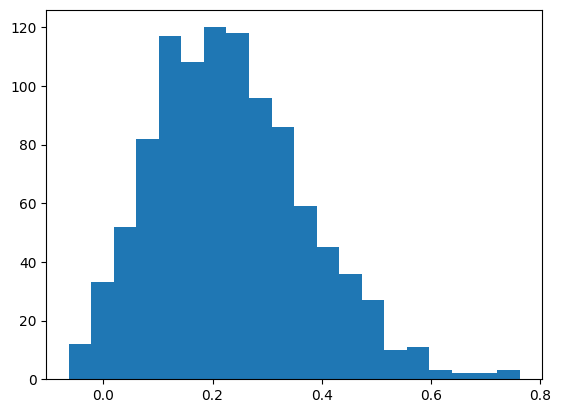

In [39]:
scores = sorted(scores, key = lambda x: x[2], reverse = True)
plt.hist([s[2] for s in scores], bins = 20)

In [40]:
import numpy as np
for score in np.arange(1.0, 0.5, -0.05):
    print(f"---Between {score} and {score - 0.05}")
    _ = [print(s[0], "\n", s[1], "\n", s[2]) for s in scores if s[2] > score and s[2] < score + 0.05]
    print()

---Between 1.0 and 0.95

---Between 0.95 and 0.8999999999999999

---Between 0.8999999999999999 and 0.8499999999999999

---Between 0.8499999999999999 and 0.7999999999999998

---Between 0.7999999999999998 and 0.7499999999999998

---Between 0.7499999999999998 and 0.6999999999999997
The proposed LM can be expanded to new domains by adding about 2% of parameters for a first domain and 13% parameters for after second domain. 
 The proposed architecture allows LMs to expand multi-domain, suppressing the increase of the number of parameters. 
 0.7619356513023376
  We propose an adapter based multi-domain Transformer based language model (LM) for Transformer ASR. 
 In this paper, we study an external LM structure for Transformer based ASR model that can be adapted for multi-domain with only 2% or 13% parameter addition per domain. 
 0.7546730637550354
The proposed model can reuse the full fine-tuned LM which is fine-tuned using all layers of an original model. 
 Finally, the proposed architectu

In [42]:
cos_sim_scores = []
for a_s in abs_sentences:
    embedding_1= model.encode(a_s, convert_to_tensor=True)
    for i, na_s in enumerate(non_abs_sentences):
        embedding_2 = model.encode(na_s, convert_to_tensor=True)
        cos_sim = util.pytorch_cos_sim(embedding_1, embedding_2)
        cos_sim_scores.append((cos_sim, a_s, na_s))

cos_sim_scores = sorted(cos_sim_scores, key = lambda x: x[0], reverse = True)
for top_sim in cos_sim_scores[:5]:
    print(top_sim[0])
    print(top_sim[1])
    print(top_sim[2])
    print()

tensor([[0.8875]])
  The long-standing one-to-many issue of the open-domain dialogues poses significant challenges for automatic evaluation methods, i.e., there may be multiple suitable responses which differ in semantics for a given conversational context.
In addition, we provide a detailed analysis of the effectiveness of our proposed method in solving the one-to-many issue in open-domain dialogue evaluation.

tensor([[0.8517]])
  The long-standing one-to-many issue of the open-domain dialogues poses significant challenges for automatic evaluation methods, i.e., there may be multiple suitable responses which differ in semantics for a given conversational context.
To tackle the one-to-many issue, we design a reference-based automatic evaluation metric (CMN), which can robustly evaluate open-domain dialogues with a single gold-standard reference.

tensor([[0.8243]])
Experimental results on two open-domain dialogue datasets demonstrate the superiority of our method compared with a wide 

### Selection of some papers for annotation (doccano)

Initial selection:

In [21]:
# select 5 random papers in acl and 5 random papers in arxiv
import random
# random seed for reproducibility
random.seed(23)
random_acl = random.sample(corpus_ACL.papers, 5)
random_arxiv = random.sample(corpus_arxiv.papers, 5)

random_list = random_acl + random_arxiv

# shuffle the list
random.shuffle(random_list)

data = []

for rp in random_list:
    contents = rp.content[["sentence", "section", "id", "candidate"]].values
    for i, row in enumerate(contents):
        if row[3] == True:
            # catch the previous sentence
            if i == 0:
                prev_sec, prev_sent = None, None
            else:
                prev_sec, prev_sent = contents[i-1][1], contents[i-1][0]

            # current sentence (the one to annotate)
            sec, sent = row[1], row[0]

            # catch the next sentence
            if i == len(contents) - 1:
                next_sec, next_sent = None, None
            else:
                next_sec, next_sent = contents[i+1][1], contents[i+1][0]

            data.append({"article_id": rp.id, "source": rp.corpus.name, "sent_id": row[2], "prev_sec": prev_sec, "prev_sent": prev_sent, "sec": sec, "sent": sent, "next_sec": next_sec, "next_sent": next_sent})


In [22]:
import pandas as pd
df_anno = pd.DataFrame(data)
df_anno

,article_id,source,sent_id,prev_sec,prev_sent,sec,sent,next_sec,next_sent
0,2012.08013,arXiv,0,None,None,abstract,The prevalence of ambiguous acronyms make sc...,abstract,We introduce new methods for acronym identific...
1,2012.08013,arXiv,1,abstract,The prevalence of ambiguous acronyms make sc...,abstract,We introduce new methods for acronym identific...,abstract,Both of our systems achieve significant perfor...
2,2012.08013,arXiv,2,abstract,We introduce new methods for acronym identific...,abstract,Both of our systems achieve significant perfor...,abstract,Our models were trained in part on new distant...
3,2012.08013,arXiv,3,abstract,Both of our systems achieve significant perfor...,abstract,Our models were trained in part on new distant...,abstract,We also identified a duplication conflict issu...
4,2012.08013,arXiv,4,abstract,Our models were trained in part on new distant...,abstract,We also identified a duplication conflict issu...,abstract,We publicly released all three of these datase...
...,...,...,...,...,...,...,...,...,...
1149,2211.05414,arXiv,228,Ethics Statement,"In our paper, we discussed the usage of ADEPT ...",Ethics Statement,It is reasonable to have concerns that a binar...,Ethics Statement,"Luckily, all pieces of ADEPT are directly exte..."
1150,2211.05414,arXiv,229,Ethics Statement,It is reasonable to have concerns that a binar...,Ethics Statement,"Luckily, all pieces of ADEPT are directly exte...",Ethics Statement,"Unfortunately, we cannot ensure or contradict ..."
1151,2211.05414,arXiv,230,Ethics Statement,"Luckily, all pieces of ADEPT are directly exte...",Ethics Statement,"Unfortunately, we cannot ensure or contradict ...",Ethics Statement,Goldfarb-Tarrant et al.
1152,2211.05414,arXiv,231,Ethics Statement,"Unfortunately, we cannot ensure or contradict ...",Ethics Statement,Goldfarb-Tarrant et al.,Ethics Statement,(2020) makes an effort to deny the causality b...


For arxiv papers, we'll redraw some articles to avoid them being part of the ACL Antho / being too recent.

In [23]:
# df_anno.to_csv("claims-to-annotate-10-papers.csv", index = False)

In [26]:
df_anno = pd.read_csv("claims-to-annotate-10-papers.csv")
df_anno = df_anno[df_anno["source"] == "ACL"]
random_acl = df_anno.article_id.unique()
print(random_acl)

['W17-4709' 'P18-1048' 'Y15-1047' 'N19-1358' '2020.signlang-1.20']


In [40]:
unpublished_NLP = pd.read_csv("arxiv-metadata-nlp-unpublished.csv")
unpublished_NLP["update_year"] = unpublished_NLP["update_date"].apply(lambda x: x[:4])
unpublished_NLP["update_year"] = unpublished_NLP["update_year"].astype(int)
unpublished_NLP["update_year"].value_counts()

2023    8868
2024    5198
2022    4439
2021    3906
2020    3332
2019    2480
2018    1821
2017    1247
2016     922
2015     468
2014     291
2008     238
2007     190
2013     161
2012     124
2011      46
2009      46
2010      40
Name: update_year, dtype: int64

In [41]:
unpublished_NLP_upto2022 = unpublished_NLP[unpublished_NLP["update_year"]<2023]
arxiv_df = pd.read_csv("arxiv-metadata-nlp-unpublished-sample-1000.csv")
arxiv_df = arxiv_df[arxiv_df["id"].isin(set(unpublished_NLP_upto2022.id.values))]
print(arxiv_df.shape)

(511, 14)


In [55]:
import random
random.seed(23)
random_arxiv = random.sample(list(arxiv_df["id"]), 5)
print(random_arxiv)

random_idx = random_arxiv + list(random_acl)
random.shuffle(random_idx)
print(random_idx)

data = []
for idx in random_idx:
    if idx in random_arxiv:
        p = corpus_arxiv.get_paper_by_id(idx)

        contents = p.content[["sentence", "section", "id", "candidate"]].values
        for i, row in enumerate(contents):
            if row[3] == True:
                # catch the previous sentence
                if i == 0:
                    prev_sec, prev_sent = None, None
                else:
                    prev_sec, prev_sent = contents[i-1][1], contents[i-1][0]

                # current sentence (the one to annotate)
                sec, sent = row[1], row[0]

                # catch the next sentence
                if i == len(contents) - 1:
                    next_sec, next_sent = None, None
                else:
                    next_sec, next_sent = contents[i+1][1], contents[i+1][0]

                data.append({"article-title": p.title, "article_id": p.id, "source": p.corpus.name, "sent_id": row[2], "prev_sec": prev_sec, "prev_sent": prev_sent, "sec": sec, "sent": sent, "next_sec": next_sec, "next_sent": next_sent})

    else:
        rows = df_anno[df_anno["article_id"] == idx]
        for i, row in rows.iterrows():
            data.append({"article-title": "", "article_id": row["article_id"], "source": "ACL", "sent_id": row["sent_id"], "prev_sec": row["prev_sec"], "prev_sent": row["prev_sent"], "sec": row["sec"], "sent": row["sent"], "next_sec": row["next_sec"], "next_sent": row["next_sent"]})


['1605.05172', '2012.04584', '2103.14302', '1708.01009', '1611.08765']
['2020.signlang-1.20', 'W17-4709', 'N19-1358', '2103.14302', 'Y15-1047', 'P18-1048', '1708.01009', '1611.08765', '1605.05172', '2012.04584']


In [56]:
df = pd.DataFrame(data)
df

,article-title,article_id,source,sent_id,prev_sec,prev_sent,sec,sent,next_sec,next_sent
0,,2020.signlang-1.20,ACL,0,NaN,NaN,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...
1,,2020.signlang-1.20,ACL,1,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...
2,,2020.signlang-1.20,ACL,2,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth..."
3,,2020.signlang-1.20,ACL,3,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...
4,,2020.signlang-1.20,ACL,4,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...,Introduction,"Therefore, most data collections contain a ver..."
...,...,...,...,...,...,...,...,...,...,...
982,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,230,CONCLUSION,"In this paper, we introduce a method to train ...",CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,"In particular, we use the cross-attention scor..."
983,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,231,CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We compare different ways to aggregate the sco...
984,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,232,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,We show that iteratively training the reader a...
985,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,233,CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,We show that iteratively training the reader a...,CONCLUSION,"In the future, we would like to explore better..."


In [57]:
df_acl = pd.read_pickle("acl-metadata-sample-1000.pkl")
id2titles = {}
for idx in random_acl:
    id2titles[idx] = df_acl[df_acl["acl_id"] == idx].title.values[0]

id2titles

{'W17-4709': 'Tree as a Pivot: Syntactic Matching Methods in Pivot Translation',
 'P18-1048': 'Self-regulation: Employing a Generative Adversarial Network to Improve Event Detection',
 'Y15-1047': 'Not Voice but Case Identity in {VP} Ellipsis of {E}nglish',
 'N19-1358': 'Playing Text-Adventure Games with Graph-Based Deep Reinforcement Learning',
 '2020.signlang-1.20': 'Recognition of Static Features in Sign Language Using Key-Points'}

In [58]:
for idx in random_acl:
    # assign the title
    df.loc[df["article_id"] == idx, "article-title"] = id2titles[idx]
df.value_counts("article-title")

article-title
Not Voice but Case Identity in {VP} Ellipsis of {E}nglish                                     183
Fill it up: Exploiting partial dependency annotations in a minimum\n  spanning tree parser    141
Self-regulation: Employing a Generative Adversarial Network to Improve Event Detection        136
Playing Text-Adventure Games with Graph-Based Deep Reinforcement Learning                     112
Siamese convolutional networks based on phonetic features for cognate\n  identification       103
Tree as a Pivot: Syntactic Matching Methods in Pivot Translation                               92
Revisiting Activation Regularization for Language RNNs                                         76
Distilling Knowledge from Reader to Retriever for Question Answering                           66
Mutually-Constrained Monotonic Multihead Attention for Online ASR                              61
Recognition of Static Features in Sign Language Using Key-Points                               17
dtype:

In [60]:
df.head()

,article-title,article_id,source,sent_id,prev_sec,prev_sent,sec,sent,next_sec,next_sent
0,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,0,NaN,NaN,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...
1,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,1,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...
2,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,2,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth..."
3,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,3,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...
4,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,4,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...,Introduction,"Therefore, most data collections contain a ver..."


In [70]:
doccano_id2article_id = {i:idx for i, idx in enumerate(random_idx)}
article_id2doccano_id = {idx:i for i, idx in enumerate(random_idx)}

In [78]:
df["article_id-d"] = df["article_id"].apply(lambda x: article_id2doccano_id[x])
df

,article-title,article_id,source,sent_id,prev_sec,prev_sent,sec,sent,next_sec,next_sent,article_id-d
0,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,0,NaN,NaN,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...,0
1,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,1,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...,0
2,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,2,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth...",0
3,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,3,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...,0
4,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,4,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...,Introduction,"Therefore, most data collections contain a ver...",0
...,...,...,...,...,...,...,...,...,...,...,...
982,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,230,CONCLUSION,"In this paper, we introduce a method to train ...",CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,"In particular, we use the cross-attention scor...",9
983,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,231,CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We compare different ways to aggregate the sco...,9
984,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,232,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,We show that iteratively training the reader a...,9
985,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,233,CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,We show that iteratively training the reader a...,CONCLUSION,"In the future, we would like to explore better...",9


In [80]:
df.to_csv("claims-to-annotate-10-papers-fulldoc.csv", index = False)
df = pd.read_csv("claims-to-annotate-10-papers-fulldoc.csv")

In [73]:
# save doccano_id2article_id as a json file
import json
with open("doccano_id2article_id-10-article.json", "w") as f:
    json.dump(doccano_id2article_id, f)

In [89]:
df_anno = df[["article_id-d", "sent_id", "sent", "sec", "prev_sec", "prev_sent", "next_sec", "next_sent"]]
df_anno["label"] = [""] * df_anno.shape[0]
df_anno = df_anno.rename(columns = {"article_id-d": "doccano_art_id", "sent_id": "sentence_id", "sent": "sentence", "sec": "current_sentence_section", "prev_sec": "previous_sentence_section", "prev_sent": "previous_sentence", "next_sec": "next_sentence_section", "next_sent": "next_sentence"})
df_anno.to_csv("claims-to-annotate-10-papers-partialdoc.csv")

C:\Users\cleme\AppData\Local\Temp\ipykernel_11684\2342835808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anno["label"] = [""] * df_anno.shape[0]


In [90]:
df_anno

,doccano_art_id,sentence_id,sentence,current_sentence_section,previous_sentence_section,previous_sentence,next_sentence_section,next_sentence,label
0,0,0,In this paper we report on a research effort f...,abstract,NaN,NaN,abstract,Three sequential models have been developed fo...,
1,0,1,Three sequential models have been developed fo...,abstract,abstract,In this paper we report on a research effort f...,abstract,The models have been applied to a Danish and a...,
2,0,2,The models have been applied to a Danish and a...,abstract,abstract,Three sequential models have been developed fo...,abstract,"Moreover, during the reported research, a meth...",
3,0,3,"Moreover, during the reported research, a meth...",abstract,abstract,The models have been applied to a Danish and a...,Introduction,One of the problems relating to sign language ...,
4,0,4,One of the problems relating to sign language ...,Introduction,abstract,"Moreover, during the reported research, a meth...",Introduction,"Therefore, most data collections contain a ver...",
...,...,...,...,...,...,...,...,...,...
982,9,230,Our approach is inspired by knowledge distilla...,CONCLUSION,CONCLUSION,"In this paper, we introduce a method to train ...",CONCLUSION,"In particular, we use the cross-attention scor...",
983,9,231,"In particular, we use the cross-attention scor...",CONCLUSION,CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,We compare different ways to aggregate the sco...,
984,9,232,We compare different ways to aggregate the sco...,CONCLUSION,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We show that iteratively training the reader a...,
985,9,233,We show that iteratively training the reader a...,CONCLUSION,CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,"In the future, we would like to explore better...",


In [96]:
random_idx

['2020.signlang-1.20',
 'W17-4709',
 'N19-1358',
 '2103.14302',
 'Y15-1047',
 'P18-1048',
 '1708.01009',
 '1611.08765',
 '1605.05172',
 '2012.04584']

In [97]:
for idx in random_idx:
    source = "arXiv" if idx in random_arxiv else "ACL"
    print(idx, source)

2020.signlang-1.20 ACL
W17-4709 ACL
N19-1358 ACL
2103.14302 arXiv
Y15-1047 ACL
P18-1048 ACL
1708.01009 arXiv
1611.08765 arXiv
1605.05172 arXiv
2012.04584 arXiv


In [104]:
reduced_list = ["2020.signlang-1.20", "W17-4709", "2103.14302", "1708.01009"]
red_doccano = [article_id2doccano_id[idx] for idx in reduced_list]
print(red_doccano)

red_df = df[df["article_id"].isin(reduced_list)]
red_df.to_csv("claims-to-annotate-4-papers-fulldoc.csv", index = False)

red_df_anno = df_anno[df_anno["doccano_art_id"].isin(red_doccano)]
red_df_anno.to_csv("claims-to-annotate-4-papers-partialdoc.csv", index = False)

[0, 1, 3, 6]


In [106]:
red_df_anno.doccano_art_id.unique()

array([0, 1, 3, 6], dtype=int64)